#Time Series Forecasting Practice

##Setup

In [ ]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

###Check GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b6adf506-1881-c5c3-1229-4c91943809e8)


###The weather Dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [ ]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

##Visualize

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

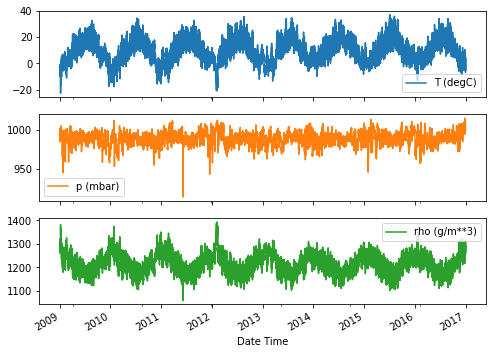

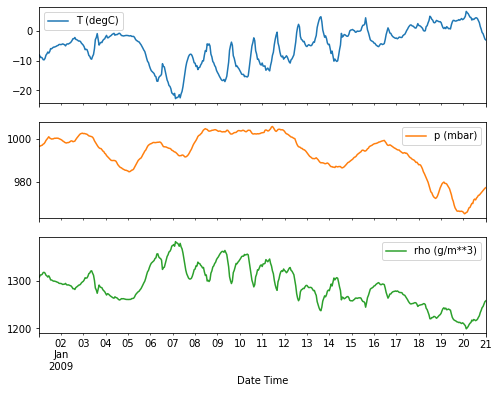

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

##Inspect and Cleanup

Next, look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


###Wind Velocity

One thing that should stand out is the min value of the wind velocity (wv (m/s)) and the maximum value (max. wv (m/s)) columns. This -9999 is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (>=0). Replace it with zeros:

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

##Split The Data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

##Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

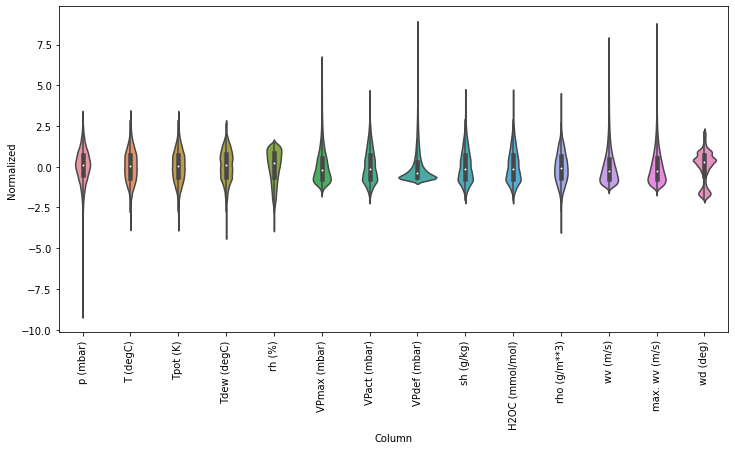

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## PART I

In PART I we will window the dataset without using `tf.keras.utils.timeseries_dataset_from_array`

###Window the dataset


In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 3 # use 3 timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


####Utilize Numpy indexing to create windowed arrays

In [ ]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

####**Create train, val, test windows and labels**

For this tutorial we will only be forecasting the temperature

#####**Train windowed & label data**

In [ ]:
train_temp_arr = train_df['T (degC)'].to_numpy()

train_windows, train_labels = make_windows(train_temp_arr, window_size=WINDOW_SIZE, horizon=HORIZON)
len(train_windows), len(train_labels)



(49060, 49060)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {train_windows[i]} -> Label: {train_labels[i]}")

Window: [-1.98247323 -2.07837211 -2.07028426] -> Label: [-2.09801405]
Window: [-2.07837211 -2.07028426 -2.09801405] -> Label: [-2.16502773]
Window: [-2.07028426 -2.09801405 -2.16502773] -> Label: [-2.16964936]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {train_windows[i-3]} -> Label: {train_labels[i-3]}")

Window: [0.93724325 0.90489182 0.87947284] -> Label: [0.74082386]
Window: [0.90489182 0.87947284 0.74082386] -> Label: [0.71078325]
Window: [0.87947284 0.74082386 0.71078325] -> Label: [0.65301284]


#####**Validation windowed & label data**

In [ ]:
val_temp_arr = val_df['T (degC)'].to_numpy()

val_windows, val_labels = make_windows(val_temp_arr, window_size=WINDOW_SIZE, horizon=HORIZON)
len(val_windows), len(val_labels)

(14015, 14015)

#####**Test windowed & label data**

In [ ]:
test_temp_arr = test_df['T (degC)'].to_numpy()

test_windows, test_labels = make_windows(test_temp_arr, window_size=WINDOW_SIZE, horizon=HORIZON)
len(test_windows), len(test_labels)

(7007, 7007)

###Naive Forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

In [ ]:
naive_forecast = train_temp_arr[:-1]
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([-1.98247323, -2.07837211, -2.07028426, -2.09801405, -2.16502773,
        -2.16964936, -2.11187895, -1.98825027, -1.93741231, -1.86577701]),
 array([1.58196102, 1.69403561, 1.66168418, 1.05509488, 0.97999335,
        0.93724325, 0.90489182, 0.87947284, 0.74082386, 0.71078325]))

####Plot Naive Forecast

#####Create a plotting function

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("T (degC)")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

(49062, 49063)

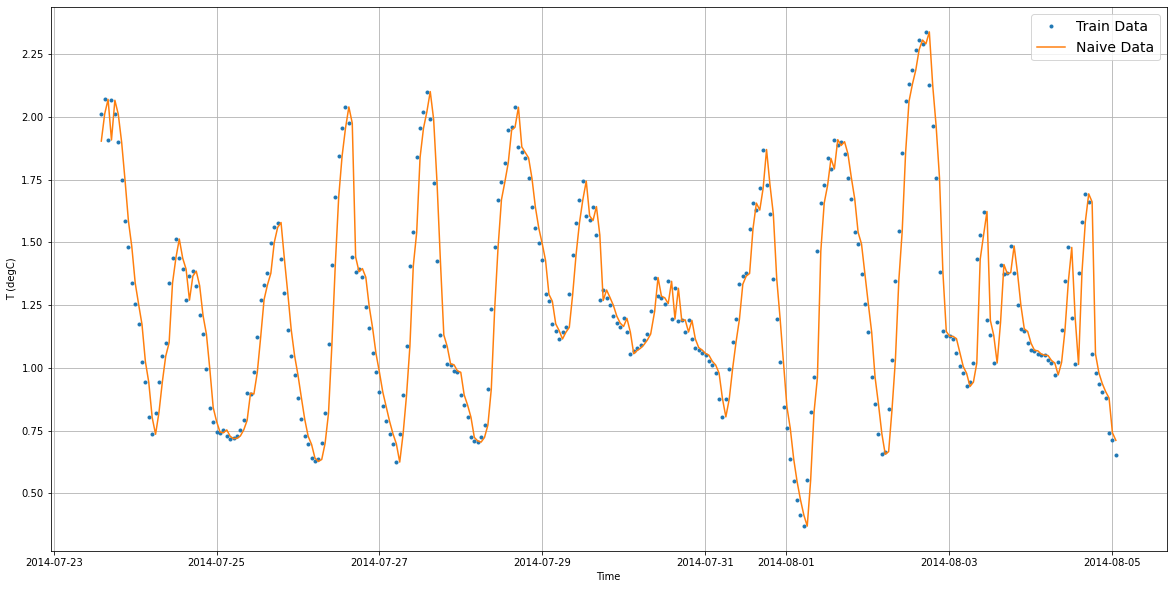

In [ ]:
plt.figure(figsize=(20, 10))

#Plot the last 300 timesteps

plot_time_series(timesteps=date_time[:len(train_temp_arr.tolist())], 
                 values=train_temp_arr, 
                 start=-300, 
                 label="Train Data")

plot_time_series(timesteps=date_time[:len(naive_forecast.tolist())+1], 
                 values=naive_forecast, 
                 start=-300,
                 format='-' ,
                 label="Naive Data")

len(naive_forecast.tolist()), len(train_temp_arr.tolist())

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

####Evaluate Naive Forecast Model

#####Metric Functions

In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=train_temp_arr[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.08293154,
 'mape': 64.16384,
 'mase': 1.0000031,
 'mse': 0.013971615,
 'rmse': 0.11820158}

Alright, looks like we've got some baselines to beat.

###Model 0

####Create Early stopping callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='auto')

####Create model

In [ ]:
from tensorflow.keras import layers

model_0 = tf.keras.Sequential([
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(HORIZON)
])

model_0.compile(loss='mae',
                optimizer=tf.optimizers.Adam(),
                metrics=['mae'])

####Fit the model

In [ ]:
history_0 = model_0.fit(x=train_windows,
                      y=train_labels,
                      epochs=100,
                      verbose=1,
                      batch_size=128,
                      validation_data=(val_windows, val_labels),
                      callbacks=[early_stopping])

Epoch 1/100
384/384 [==============================] - 2s 5ms/step - loss: 0.1209 - mae: 0.1209 - val_loss: 0.0662 - val_mae: 0.0662
Epoch 2/100
384/384 [==============================] - 2s 5ms/step - loss: 0.0651 - mae: 0.0651 - val_loss: 0.0643 - val_mae: 0.0643
Epoch 3/100
384/384 [==============================] - 2s 5ms/step - loss: 0.0637 - mae: 0.0637 - val_loss: 0.0602 - val_mae: 0.0602
Epoch 4/100
384/384 [==============================] - 1s 3ms/step - loss: 0.0629 - mae: 0.0629 - val_loss: 0.0609 - val_mae: 0.0609
Epoch 5/100
384/384 [==============================] - 1s 3ms/step - loss: 0.0628 - mae: 0.0628 - val_loss: 0.0607 - val_mae: 0.0607


####Evaluate the model

In [ ]:
model_0.evaluate(test_windows, test_labels)

219/219 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.0624


[0.062379393726587296, 0.062379393726587296]

####Making forecasts with a model (on the test dataset)

Since we're going to be running more modelling experiments, let's write a function which:

1. Takes in a trained model (just like model_1)

2. Takes in some input data (just like the data the model was trained on)

3. Passes the input data to the model's predict() method

4. Returns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

Now let's use our make_preds() and see how it goes.

In [ ]:
model_0_preds = make_preds(model_0, test_windows)
model_0_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.7762238 , -0.8557154 , -0.83813643, -0.81389385, -0.82848483,
       -0.85187477, -0.86569726, -0.8535028 , -0.8594034 , -0.8707391 ],
      dtype=float32)>

In [ ]:
model_0_results = evaluate_preds(tf.squeeze(test_labels), model_0_preds)
model_0_results

{'mae': 0.062379405,
 'mape': 46.208904,
 'mase': 0.7323052,
 'mse': 0.008294873,
 'rmse': 0.091076195}

We beat the baseline!

####Lets plot model_0

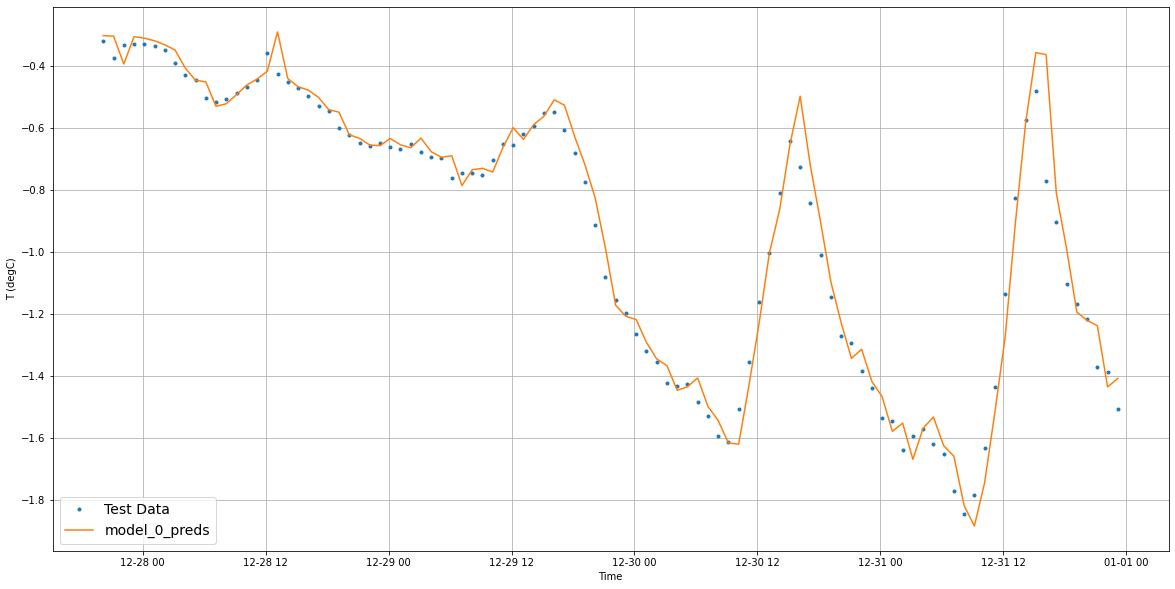

In [ ]:
plt.figure(figsize=(20, 10))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=date_time[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=-100, 
                 label="Test Data")

plot_time_series(timesteps=date_time[-len(test_windows):],
                 values=model_0_preds,
                 start=-100, 
                 format="-",
                 label="model_0_preds")

####Plot model loss curves

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # accuracy = history.history['accuracy']
  # val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()


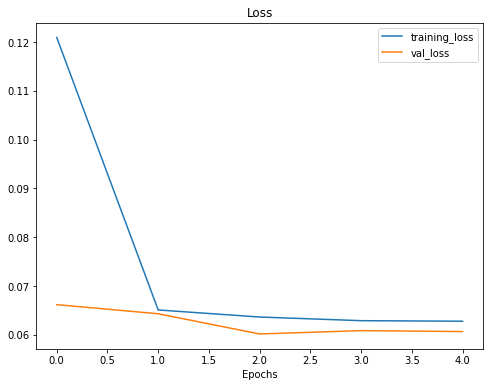

In [ ]:
plot_loss_curves(history_0)

##PART II

Now lets redo the above but with tensorflows `tf.keras.utils.timeseries_dataset_from_array`

###Create Train, Val & Test tf.data.Datasets

####Train

In [ ]:
train_target_slice = train_temp_arr.size-WINDOW_SIZE
train_tfds = tf.keras.utils.timeseries_dataset_from_array(data=train_temp_arr,
                                                  targets=train_temp_arr[WINDOW_SIZE:],
                                                  sequence_stride=1,
                                                  shuffle=False,
                                                  sequence_length=WINDOW_SIZE,
                                                  batch_size=32)

sub_train_tfds = train_tfds.take(2)

for window in sub_train_tfds:
  print(window)

(<tf.Tensor: shape=(32, 3), dtype=float64, numpy=
array([[-1.98247323, -2.07837211, -2.07028426],
       [-2.07837211, -2.07028426, -2.09801405],
       [-2.07028426, -2.09801405, -2.16502773],
       [-2.09801405, -2.16502773, -2.16964936],
       [-2.16502773, -2.16964936, -2.11187895],
       [-2.16964936, -2.11187895, -1.98825027],
       [-2.11187895, -1.98825027, -1.93741231],
       [-1.98825027, -1.93741231, -1.86577701],
       [-1.93741231, -1.86577701, -1.90852711],
       [-1.86577701, -1.90852711, -1.84613507],
       [-1.90852711, -1.84613507, -1.73290507],
       [-1.84613507, -1.73290507, -1.73868211],
       [-1.73290507, -1.73868211, -1.7097969 ],
       [-1.73868211, -1.7097969 , -1.67629006],
       [-1.7097969 , -1.67629006, -1.67282384],
       [-1.67629006, -1.67282384, -1.65895894],
       [-1.67282384, -1.65895894, -1.64278323],
       [-1.65895894, -1.64278323, -1.61851966],
       [-1.64278323, -1.61851966, -1.60696557],
       [-1.61851966, -1.60696557, -1.5

####Val

In [ ]:
val_tfds = tf.keras.utils.timeseries_dataset_from_array(data=val_temp_arr,
                                                  targets=val_temp_arr[WINDOW_SIZE:],
                                                  sequence_stride=1,
                                                  shuffle=False,
                                                  sequence_length=WINDOW_SIZE,
                                                  batch_size=32)

####Test

In [ ]:
test_tfds = tf.keras.utils.timeseries_dataset_from_array(data=test_temp_arr,
                                                  targets=test_temp_arr[WINDOW_SIZE:],
                                                  sequence_stride=1,
                                                  shuffle=False,
                                                  sequence_length=WINDOW_SIZE,
                                                  batch_size=32)

###Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_tfds = train_tfds.cache().prefetch(buffer_size=AUTOTUNE)
val_tfds = val_tfds.cache().prefetch(buffer_size=AUTOTUNE)
test_tfds = test_tfds.cache().prefetch(buffer_size=AUTOTUNE)

###Create new model

In [ ]:
model_1 = tf.keras.Sequential([
  layers.Input(shape=(WINDOW_SIZE)),                             
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(HORIZON)
])

model_1.compile(loss='mae',
                optimizer=tf.optimizers.Adam(),
                metrics=['mae'])

In [ ]:
history_1 = model_1.fit(train_tfds,
                      epochs=100,
                      verbose=1,
                      batch_size=128,
                      validation_data=val_tfds,
                      callbacks=[early_stopping])

Epoch 1/100
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0846 - mae: 0.0846 - val_loss: 0.0687 - val_mae: 0.0687
Epoch 2/100
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0669 - mae: 0.0669 - val_loss: 0.0714 - val_mae: 0.0714
Epoch 3/100
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0661 - mae: 0.0661 - val_loss: 0.0682 - val_mae: 0.0682
Epoch 4/100
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0663 - mae: 0.0663 - val_loss: 0.0673 - val_mae: 0.0673
Epoch 5/100
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0647 - mae: 0.0647 - val_loss: 0.0723 - val_mae: 0.0723
Epoch 6/100
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0644 - mae: 0.0644 - val_loss: 0.0719 - val_mae: 0.0719


###Evaluate Model

In [ ]:
model_1.evaluate(test_tfds)

219/219 [==============================] - 1s 6ms/step - loss: 0.0701 - mae: 0.0701


[0.07009410113096237, 0.07009410113096237]

In [ ]:
model_1_preds = model_1.predict(test_tfds)

####Plot predictions

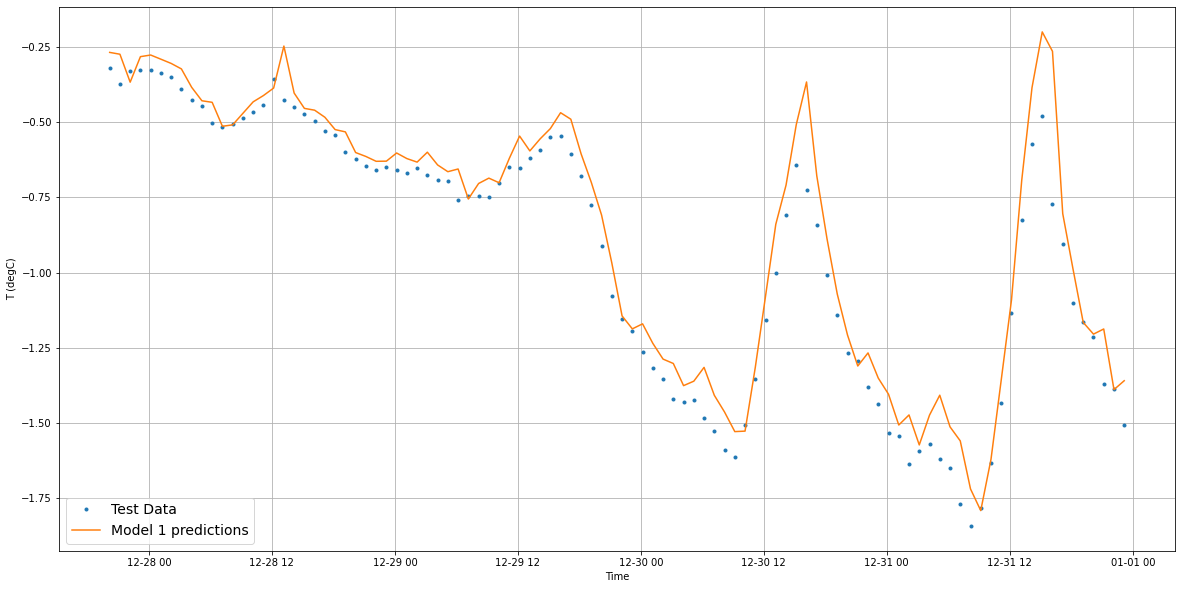

In [ ]:
plt.figure(figsize=(20, 10))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=date_time[-len(model_1_preds):], 
                 values=test_labels[:, 0], 
                 start=-100, 
                 label="Test Data")

plot_time_series(timesteps=date_time[-len(model_1_preds):],
                 values=model_1_preds,
                 start=-100, 
                 format="-",
                 label="Model 1 predictions")